# Практическое задание №4 по теме "Сверточные нейронные сети".

1. обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10
2. оценить рост точности при увеличении ширины сети (больше фильтров)
3. оценить рост точности при увеличении глубины сети (больше слоев)
4. *сравнить с точностью полносвязной сети для этой выборки

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.random.set_seed(123)

In [4]:
models = [] 
train_acc = []
test_acc = [] 

## Загрузка данных

In [5]:
num_classes = 10
# разделение тренировочной и тестовой выборки
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'тренировочные примеры')
print(X_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [6]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

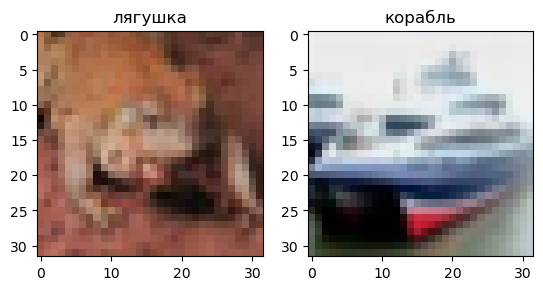

In [7]:
plt.subplot(1, 2, 1)
plt.imshow(X_test[5])
plt.title(f"{classes[np.argmax(y_test[5,:])]}")
plt.subplot(1, 2, 2)
plt.imshow(X_test[1])
plt.title(f"{classes[np.argmax(y_test[1,:])]}")
plt.show()

## Задание 1

Обучим сверточную нейронную сеть на датасете cifar-10.

In [8]:
batch_size = 128
epochs = 10

In [9]:
# конфигурирование слоев нейросети
model_base = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model_base.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_base.add(Activation('relu'))
model_base.add(Conv2D(32, (3, 3)))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2)))
model_base.add(Dropout(0.25))

model_base.add(Conv2D(64, (3, 3), padding='same'))
model_base.add(Activation('relu'))
model_base.add(Conv2D(64, (3, 3)))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2)))
model_base.add(Dropout(0.25))

# полносвязные слои нейронной сети
model_base.add(Flatten())
model_base.add(Dense(128))
model_base.add(Activation('relu'))
model_base.add(Dense(128))
model_base.add(Activation('relu'))
model_base.add(Dropout(0.5))
model_base.add(Dense(num_classes))
model_base.add(Activation('softmax'))

# model.summary()
# компиляция модели
model_base.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [10]:
with tf.device("GPU:0"):
    history_base = model_base.fit(X_train, 
                                  y_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  validation_data=(X_test, y_test),
                                  verbose=2)

Epoch 1/10
391/391 - 7s - loss: 1.7406 - accuracy: 0.3537 - val_loss: 1.3417 - val_accuracy: 0.5126 - 7s/epoch - 19ms/step
Epoch 2/10
391/391 - 4s - loss: 1.3257 - accuracy: 0.5270 - val_loss: 1.1618 - val_accuracy: 0.5919 - 4s/epoch - 11ms/step
Epoch 3/10
391/391 - 4s - loss: 1.1664 - accuracy: 0.5878 - val_loss: 1.0218 - val_accuracy: 0.6361 - 4s/epoch - 11ms/step
Epoch 4/10
391/391 - 4s - loss: 1.0373 - accuracy: 0.6404 - val_loss: 0.9285 - val_accuracy: 0.6756 - 4s/epoch - 11ms/step
Epoch 5/10
391/391 - 5s - loss: 0.9397 - accuracy: 0.6724 - val_loss: 0.8726 - val_accuracy: 0.6943 - 5s/epoch - 12ms/step
Epoch 6/10
391/391 - 4s - loss: 0.8691 - accuracy: 0.6977 - val_loss: 0.8243 - val_accuracy: 0.7131 - 4s/epoch - 11ms/step
Epoch 7/10
391/391 - 4s - loss: 0.8243 - accuracy: 0.7168 - val_loss: 0.7782 - val_accuracy: 0.7313 - 4s/epoch - 11ms/step
Epoch 8/10
391/391 - 4s - loss: 0.7656 - accuracy: 0.7364 - val_loss: 0.7431 - val_accuracy: 0.7436 - 4s/epoch - 11ms/step
Epoch 9/10
391/3

In [11]:
with tf.device("GPU:0"):
    tr_loss, tr_acc = model_base.evaluate(X_train, y_train, verbose=0)
    te_loss, te_acc = model_base.evaluate(X_test, y_test, verbose=0)

models.append('Базовая модель')
train_acc.append(round(tr_acc, 2))
test_acc.append(round(te_acc, 2))

## Задание 2

Оценим рост точности при увеличении ширины сети (больше фильтров).

Увеличили количество фильтров в 2 раза.

In [12]:
# конфигурирование слоев нейросети
model_wide = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model_wide.add(Conv2D(62, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_wide.add(Activation('relu'))
model_wide.add(Conv2D(64, (3, 3)))
model_wide.add(Activation('relu'))
model_wide.add(MaxPooling2D(pool_size=(2, 2)))
model_wide.add(Dropout(0.25))

model_wide.add(Conv2D(128, (3, 3), padding='same'))
model_wide.add(Activation('relu'))
model_wide.add(Conv2D(128, (3, 3)))
model_wide.add(Activation('relu'))
model_wide.add(MaxPooling2D(pool_size=(2, 2)))
model_wide.add(Dropout(0.25))

# полносвязные слои нейронной сети
model_wide.add(Flatten())
model_wide.add(Dense(128))
model_wide.add(Activation('relu'))
model_wide.add(Dense(128))
model_wide.add(Activation('relu'))
model_wide.add(Dropout(0.5))
model_wide.add(Dense(num_classes))
model_wide.add(Activation('softmax'))

# model.summary()
# компиляция модели
model_wide.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [13]:
with tf.device("GPU:0"):
    history_wide = model_wide.fit(X_train, 
                                  y_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  validation_data=(X_test, y_test),
                                  verbose=2)

Epoch 1/10
391/391 - 9s - loss: 1.7061 - accuracy: 0.3671 - val_loss: 1.3247 - val_accuracy: 0.5115 - 9s/epoch - 24ms/step
Epoch 2/10
391/391 - 7s - loss: 1.2487 - accuracy: 0.5573 - val_loss: 1.0612 - val_accuracy: 0.6284 - 7s/epoch - 19ms/step
Epoch 3/10
391/391 - 8s - loss: 1.0388 - accuracy: 0.6369 - val_loss: 0.8928 - val_accuracy: 0.6945 - 8s/epoch - 20ms/step
Epoch 4/10
391/391 - 8s - loss: 0.9097 - accuracy: 0.6847 - val_loss: 0.8249 - val_accuracy: 0.7120 - 8s/epoch - 21ms/step
Epoch 5/10
391/391 - 8s - loss: 0.8089 - accuracy: 0.7217 - val_loss: 0.7863 - val_accuracy: 0.7255 - 8s/epoch - 20ms/step
Epoch 6/10
391/391 - 8s - loss: 0.7375 - accuracy: 0.7487 - val_loss: 0.7158 - val_accuracy: 0.7513 - 8s/epoch - 20ms/step
Epoch 7/10
391/391 - 8s - loss: 0.6753 - accuracy: 0.7680 - val_loss: 0.6836 - val_accuracy: 0.7666 - 8s/epoch - 20ms/step
Epoch 8/10
391/391 - 8s - loss: 0.6390 - accuracy: 0.7818 - val_loss: 0.6780 - val_accuracy: 0.7688 - 8s/epoch - 20ms/step
Epoch 9/10
391/3

In [14]:
with tf.device("GPU:0"):
    tr_loss, tr_acc = model_wide.evaluate(X_train, y_train, verbose=0)
    te_loss, te_acc = model_wide.evaluate(X_test, y_test, verbose=0)
    
models.append('Больше фильтров х2')
train_acc.append(round(tr_acc, 2))
test_acc.append(round(te_acc, 2))

## Задание 3

Оценим рост точности при увеличении глубины сети (больше слоев)

In [15]:
# конфигурирование слоев нейросети
model_deep = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model_deep.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_deep.add(Activation('relu'))
model_deep.add(Conv2D(32, (3, 3)))
model_deep.add(Activation('relu'))
model_deep.add(MaxPooling2D(pool_size=(2, 2)))
model_deep.add(Dropout(0.25))

model_deep.add(Conv2D(64, (3, 3), padding='same'))
model_deep.add(Activation('relu'))
model_deep.add(Conv2D(64, (3, 3)))
model_deep.add(Activation('relu'))
model_deep.add(MaxPooling2D(pool_size=(2, 2)))
model_deep.add(Dropout(0.25))

# увеличили глубину
model_deep.add(Conv2D(64, (3, 3), padding='same'))
model_deep.add(Activation('relu'))
model_deep.add(Conv2D(64, (3, 3)))
model_deep.add(Activation('relu'))
model_deep.add(MaxPooling2D(pool_size=(2, 2)))
model_deep.add(Dropout(0.25))

# полносвязные слои нейронной сети
model_deep.add(Flatten())
model_deep.add(Dense(128))
model_deep.add(Activation('relu'))
model_deep.add(Dense(128))
model_deep.add(Activation('relu'))
model_deep.add(Dropout(0.5))
model_deep.add(Dense(num_classes))
model_deep.add(Activation('softmax'))

# model.summary()
# компиляция модели
model_deep.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [16]:
with tf.device("GPU:0"):
    history_deep = model_deep.fit(X_train, 
                                  y_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  validation_data=(X_test, y_test),
                                  verbose=2)

Epoch 1/10
391/391 - 6s - loss: 1.9190 - accuracy: 0.2714 - val_loss: 1.5414 - val_accuracy: 0.4275 - 6s/epoch - 15ms/step
Epoch 2/10
391/391 - 5s - loss: 1.4634 - accuracy: 0.4686 - val_loss: 1.2847 - val_accuracy: 0.5387 - 5s/epoch - 12ms/step
Epoch 3/10
391/391 - 5s - loss: 1.2568 - accuracy: 0.5491 - val_loss: 1.0699 - val_accuracy: 0.6166 - 5s/epoch - 12ms/step
Epoch 4/10
391/391 - 5s - loss: 1.1339 - accuracy: 0.5986 - val_loss: 0.9994 - val_accuracy: 0.6413 - 5s/epoch - 12ms/step
Epoch 5/10
391/391 - 5s - loss: 1.0378 - accuracy: 0.6376 - val_loss: 0.9417 - val_accuracy: 0.6692 - 5s/epoch - 13ms/step
Epoch 6/10
391/391 - 5s - loss: 0.9676 - accuracy: 0.6633 - val_loss: 0.8723 - val_accuracy: 0.6955 - 5s/epoch - 13ms/step
Epoch 7/10
391/391 - 5s - loss: 0.9126 - accuracy: 0.6849 - val_loss: 0.7931 - val_accuracy: 0.7236 - 5s/epoch - 12ms/step
Epoch 8/10
391/391 - 5s - loss: 0.8668 - accuracy: 0.7035 - val_loss: 0.7624 - val_accuracy: 0.7370 - 5s/epoch - 12ms/step
Epoch 9/10
391/3

In [17]:
with tf.device("GPU:0"):
    tr_loss, tr_acc = model_deep.evaluate(X_train, y_train, verbose=0)
    te_loss, te_acc = model_deep.evaluate(X_test, y_test, verbose=0)

models.append('Более глубокая +2 слоя')
train_acc.append(round(tr_acc, 2))
test_acc.append(round(te_acc, 2))

## Задание 4

Обучим полносвязную сеть на датасете cifar-10 и сравним точность с другими сверточными сетями.

In [25]:
# конфигурирование слоев нейросети
model_full = Sequential()

# полносвязные слои нейронной сети
model_full.add(Flatten(input_shape=X_train.shape[1:]))
model_full.add(Dense(256))
model_full.add(Activation('relu'))
model_full.add(Dense(256))
model_full.add(Activation('relu'))
model_full.add(Dense(64))
model_full.add(Activation('relu'))
model_full.add(Dense(num_classes))
model_full.add(Activation('softmax'))

# model_full.summary()
# компиляция модели
model_full.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [26]:
history_full = model_full.fit(X_train, 
                                  y_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  validation_data=(X_test, y_test),
                                  verbose=2)

Epoch 1/10
391/391 - 2s - loss: 1.8926 - accuracy: 0.3113 - val_loss: 1.7411 - val_accuracy: 0.3683 - 2s/epoch - 5ms/step
Epoch 2/10
391/391 - 2s - loss: 1.6879 - accuracy: 0.3934 - val_loss: 1.6591 - val_accuracy: 0.4013 - 2s/epoch - 4ms/step
Epoch 3/10
391/391 - 2s - loss: 1.6006 - accuracy: 0.4270 - val_loss: 1.5682 - val_accuracy: 0.4399 - 2s/epoch - 4ms/step
Epoch 4/10
391/391 - 2s - loss: 1.5408 - accuracy: 0.4482 - val_loss: 1.5250 - val_accuracy: 0.4529 - 2s/epoch - 4ms/step
Epoch 5/10
391/391 - 2s - loss: 1.4924 - accuracy: 0.4686 - val_loss: 1.5032 - val_accuracy: 0.4700 - 2s/epoch - 4ms/step
Epoch 6/10
391/391 - 2s - loss: 1.4657 - accuracy: 0.4785 - val_loss: 1.4874 - val_accuracy: 0.4709 - 2s/epoch - 4ms/step
Epoch 7/10
391/391 - 2s - loss: 1.4311 - accuracy: 0.4890 - val_loss: 1.4586 - val_accuracy: 0.4801 - 2s/epoch - 4ms/step
Epoch 8/10
391/391 - 2s - loss: 1.4051 - accuracy: 0.4985 - val_loss: 1.4205 - val_accuracy: 0.4953 - 2s/epoch - 4ms/step
Epoch 9/10
391/391 - 2s 

In [27]:
tr_loss, tr_acc = model_full.evaluate(X_train, y_train, verbose=0)
te_loss, te_acc = model_full.evaluate(X_test, y_test, verbose=0)

models.append('Полносвязная сеть')
train_acc.append(round(tr_acc, 2))
test_acc.append(round(te_acc, 2))

---

## Вывод

In [28]:
results = pd.DataFrame()
results['model'] = models
results['train_acc'] = train_acc
results['test_acc'] = test_acc

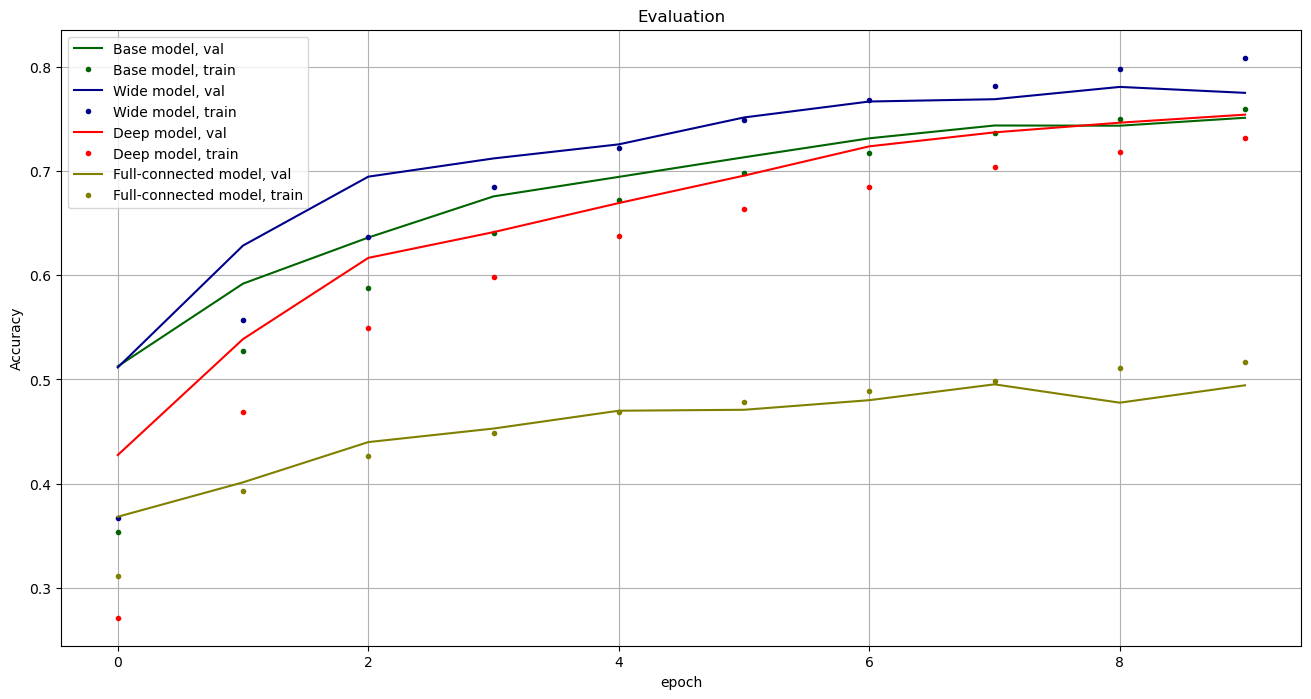

In [29]:
plt.figure(figsize=(16,8))
plt.plot(history_base.history['val_accuracy'], c='darkgreen', label=f'Base model, val')
plt.plot(history_base.history['accuracy'], '.', c='darkgreen', label=f'Base model, train')
plt.plot(history_wide.history['val_accuracy'], c='darkblue', label=f'Wide model, val')
plt.plot(history_wide.history['accuracy'], '.', c='darkblue', label=f'Wide model, train')
plt.plot(history_deep.history['val_accuracy'], c='red', label=f'Deep model, val')
plt.plot(history_deep.history['accuracy'], '.', c='red', label=f'Deep model, train')
plt.plot(history_full.history['val_accuracy'], c='olive', label=f'Full-connected model, val')
plt.plot(history_full.history['accuracy'], '.', c='olive', label=f'Full-connected model, train')
plt.title('Evaluation')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

In [30]:
results

,model,train_acc,test_acc
0,Базовая модель,0.82,0.75
1,Больше фильтров х2,0.86,0.77
2,Более глубокая +2 слоя,0.79,0.75
3,Полносвязная сеть,0.54,0.49


Полносвязная модель покала худшие результаты, что еще раз подверждает эффективность сверточных нейронных сетей для классификации объектов на изображении.

Увеличение глубины сети и количества фильтров помогли улучшить качество базовой модели.

Лучший результат показала базовая модель с увеличенным количеством фильтров.

---